<a href="https://colab.research.google.com/github/nibim/coursework/blob/main/pytorch/animal_images_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")


Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


In [35]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy  as np
import os

device= "cuda" if torch.cuda.is_available() else "cpu"
print("Device availble: ", device)




Device availble:  cuda


In [36]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
      for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
        image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
        labels.append(label)


data_df = pd.DataFrame(zip(image_path, labels) , columns = ["image_path", "labels"])
data_df.head()


,image_path,labels
0,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
1,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
2,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
3,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat
4,/content/animal-faces/afhq/val/cat/pixabay_cat...,cat


In [37]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index) #removes those rows from the original dataset.

val = test.sample(frac = 0.5)
test = test.sample(frac = 0.5)
print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2420, 2)


In [38]:
label_encoder = LabelEncoder() # It converts categorical text labels (like "cat", "dog", "tiger") into integer numbers (like 0, 1, 2)
label_encoder.fit(data_df["labels"])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [39]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(
            label_encoder.transform(dataframe['labels'])
        ).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image).to(device)

        return image, label


In [40]:
train_dataset = CustomImageDataset(dataframe = train , transform = transform)
val_dataset = CustomImageDataset(dataframe = val , transform = transform)
test_dataset = CustomImageDataset(dataframe = test , transform = transform)

In [41]:
 #1234

In [42]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10


In [43]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [44]:
#Building the model
class Net (nn.Module):
  def __init__(self):
     super().__init__()

     #We are making the layers
     self.conv1 = nn.Conv2d(3,32, kernel_size=3, padding = 1)
     self.conv2 = nn.Conv2d(32,64, kernel_size=3, padding = 1)
     self.conv3 = nn.Conv2d(64,128, kernel_size=3, padding = 1)

     self.pooling = nn.MaxPool2d(2,2)

     self.relu = nn.ReLU()

     self.flatten = nn.Flatten()

     self.linear = nn.Linear(128*16*16, 128)
     self.output = nn.Linear(128, len(data_df['labels'].unique()))


     """
     EXPLANATION:
     we try to assemble cnn: https://medium.com/@alejandro.itoaramendia/convolutional-neural-networks-cnns-a-complete-guide-a803534a1930

     conv2d(in_channels, out_channels, kernel_size ) try to extract more and more features from the image.so it does not change the image size but it increases the number of features
     kernel_size= 3 means our filter size is equal to 3.
     pooling try to keep the most important part of each image so the number of each pixels in width and height decreases!
     In simple words:      ReLU helps the CNN understand complicated patterns by making the network nonlinear. Without ReLU, a CNN would be completely useless
     at the end the output use 128 neurons to analys each of these 128 features!
     """

  def forward(self, x):
    x = self.conv1(x)   #(32, 128, 128)
    x = self.pooling(x) #(32, 64, 64)
    x = self.relu(x)

    x = self.conv2(x)  #(64, 64, 64)
    x = self.pooling(x)   #(64,32,32)
    x = self.relu(x)

    x = self.conv3(x) #(12, 32, 32)
    x = self.pooling(x) #(32, 16,16)
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)

    return x



In [45]:
model = Net().to(device)

In [46]:

from torchsummary import summary
summary(model, input_size = (3,128,128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [31]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc

        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))

    total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__()) * 100, 4))
    total_acc_validation_plot.append(round((total_acc_val/val_dataset.__len__()) * 100, 4))

    print(f'''Epoch {epoch+1}/{EPOCHS},
    Train Loss: {round(total_loss_train/1000, 4)}
    Train Accuracy: {round((total_acc_train/train_dataset.__len__()) * 100, 4)}
    Validation Loss: {round(total_loss_val/1000, 4)}
    Validation Accuracy: {round((total_acc_val/val_dataset.__len__()) * 100, 4)}
    ''')



Epoch 1/10, 
    Train Loss: 0.3198 
    Train Accuracy: 81.534
    Validation Loss: 0.0438 
    Validation Accuracy: 89.4215
    
Epoch 2/10, 
    Train Loss: 0.1383 
    Train Accuracy: 92.7819
    Validation Loss: 0.0287 
    Validation Accuracy: 93.1405
    
Epoch 3/10, 
    Train Loss: 0.092 
    Train Accuracy: 95.2971
    Validation Loss: 0.0227 
    Validation Accuracy: 93.843
    
Epoch 4/10, 
    Train Loss: 0.0656 
    Train Accuracy: 96.6522
    Validation Loss: 0.0218 
    Validation Accuracy: 94.7934
    
Epoch 5/10, 
    Train Loss: 0.0518 
    Train Accuracy: 97.219
    Validation Loss: 0.0183 
    Validation Accuracy: 95.8678
    
Epoch 6/10, 
    Train Loss: 0.0367 
    Train Accuracy: 98.2021
    Validation Loss: 0.0163 
    Validation Accuracy: 96.0744
    
Epoch 7/10, 
    Train Loss: 0.0256 
    Train Accuracy: 98.7601
    Validation Loss: 0.0182 
    Validation Accuracy: 96.0331
    
Epoch 8/10, 
    Train Loss: 0.0203 
    Train Accuracy: 99.0169
    Validation 

In [32]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)

        acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
        total_acc_test += acc
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 96.4876 and Loss is 0.0184


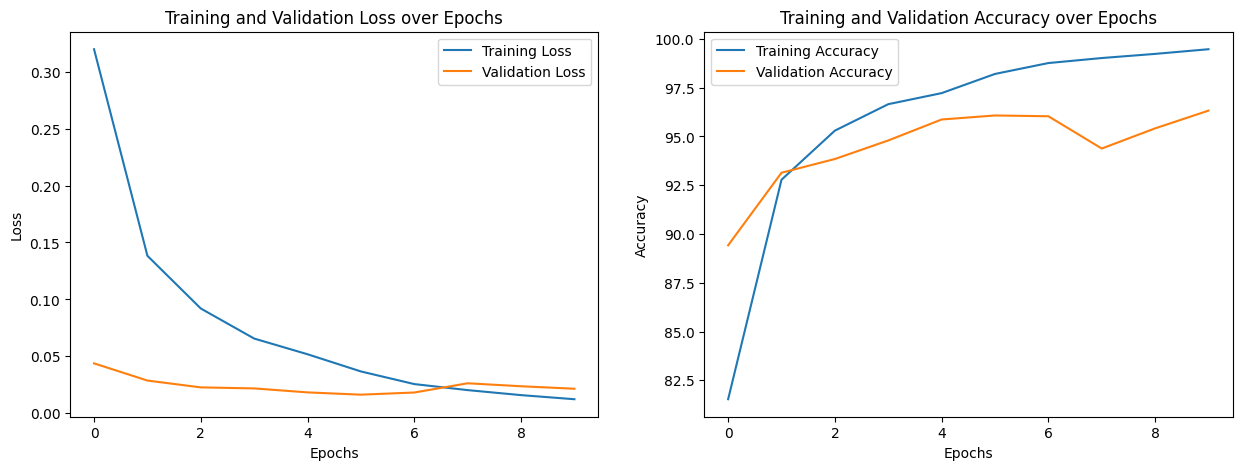

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()
